In [52]:
import os
import cv2
import tqdm
import shutil

import numpy as np
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt

In [31]:
ROOT_DIR = '/opt/ml/input/data'
CSV_PATH = '/opt/ml/input/mmsegmentation/work_dirs/upernet_beit_large_Albu/upernet_beit_large_Albu_512x512_for_pseudo_labelling.csv'

In [55]:
data = pd.read_csv(CSV_PATH)
data

,image_id,PredictionString
0,batch_01_vt/0021.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,batch_01_vt/0028.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,batch_01_vt/0031.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,batch_01_vt/0032.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,batch_01_vt/0076.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...
619,batch_02_vt/1949.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
620,batch_02_vt/1960.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
621,batch_02_vt/1974.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
622,batch_02_vt/1990.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [33]:
class_colormap = pd.read_csv("class_dict.csv")

def create_trash_label_colormap():
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

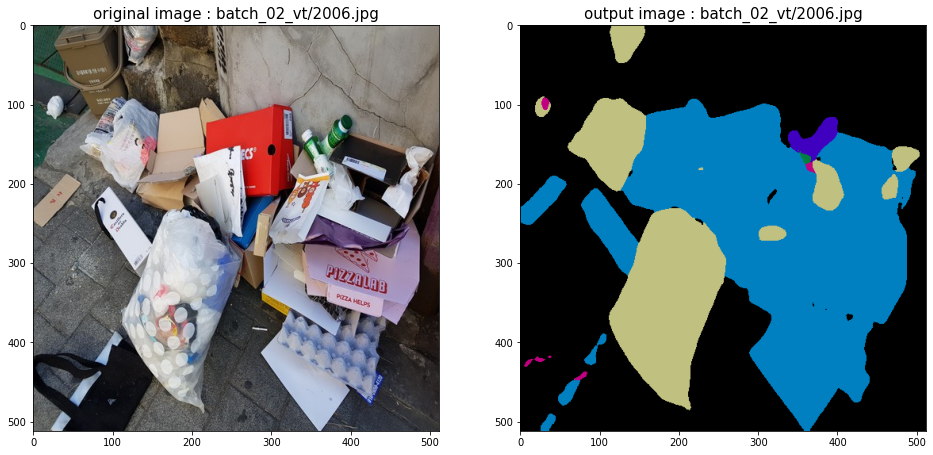

In [64]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

num = 623

ori_image = cv2.imread(os.path.join(ROOT_DIR, data['image_id'][num]))
ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)
ax1.imshow(ori_image)
ax1.grid(False)
ax1.set_title('original image : {}'.format(data['image_id'][num]), fontsize=15)

output_image = np.array(data['PredictionString'][num].split(' '), dtype=np.int8).reshape(512, 512)
output_image = label_to_color_image(output_image)
ax2.imshow(output_image)
ax2.grid(False)
ax2.set_title('output image : {}'.format(data['image_id'][num]), fontsize=15)

plt.show()

In [65]:
start_index = 2617

for idx in range(len(data)):
    image_id, prediction_string = data['image_id'][idx], data['PredictionString'][idx]
    ori_image_path = os.path.join(ROOT_DIR, image_id)
    copy_to = f'/opt/ml/input/data/pseudo_labelling_data/images/train/{start_index+idx}.jpg'
    shutil.copyfile(ori_image_path, copy_to)

    mask_image = np.array(prediction_string.split(' '), dtype=np.int8).reshape(512, 512)
    save_to = f'/opt/ml/input/data/pseudo_labelling_data/annotations/train/{start_index+idx}.png'
    cv2.imwrite(save_to, mask_image)